# Final Project

Molly Siebecker

DATA 604

CUNY SPS

Summer 2024

# Problem

Let's say that we have a county library system with two categories of books: standard books and new arrivals. To account for the higher demand of the new arrivals, they are limited to a check out time of only two weeks, as opposed to the standard three weeks. New arrivals are moved into the standard category after six months.

This library system has multiple branches, and patrons can request books currently located at any branch. Patrons request a book online, at which point their place in line is held. Once a copy is available, it is transported to the patron's selected branch, where it is held until they pick it up. Once the book is due, it is either returned, or it becomes overdue. Once overdue, it can either be returned (late,) or, after a time limit, it is deemed "lost" and the patron must pay for a replacement. Returned books are placed back on the shelf.

The library is seeking to maximize the percentage of the total books that are either available (on the shelf) or currently in the hands of a reader (checked out,) excluding books that are overdue or lost. One way to increase the number of books available is to provide longer check out times, for both the standard books and the new books. In this simulation, I will look to find the combination or ratio of check out times that maximizes the percentage of books that are either available or checked out.

Libraries perform an essential public service, and it is in their interest and the interest of their patrons to keep as many books either available to be checked out or in the hands of readers as possible.

# Flow-Chart Model

![Library System Flow Chart](https://github.com/mollysiebecker/cunysps_data604/blob/main/604_final_flow_chart.jpg?raw=true)

# Simulation

In [450]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

# import libraries and functions

from modsim import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

random.seed(24)

## Defining Parameters and Functions

In [451]:
# define number of days until new requests come in
standard_request_time = 2
new_request_time = 1

alpha = 1 / standard_request_time
beta = 1 / new_request_time

# define number of days patrons wait in line after request
wait_time_standard = 3
wait_time_new = 21

gamma = 1 / wait_time_standard
delta = 1 / wait_time_new

# define number of days in transit
time_in_transit = 4

epsilon = 1 / time_in_transit

# define number of days a books waits to be picked up
days_awaiting_pickup = 3

zeta = 1 / days_awaiting_pickup

# define check out times
standard_check_out_time = 21
new_check_out_time = 14

eta = 1 / standard_check_out_time
theta = 1 / new_check_out_time

# define fraction of patrons that return book (both on time and eventually)
kappa = 0.9

# define number of days until book is considered lost
time_until_lost = 30

iota = 1 / time_until_lost

# define number of days to re-shelve returned book
time_until_shelved = 1

mu = 1 / time_until_shelved

# define number of days to replace lost book
time_until_replaced = 10

nu = 1 / time_until_replaced

# define number of days until a new book is re-categorized as standard
time_until_standard = 156

rho = 1 / time_until_standard

# define number of new books per day
new_orders = 20

The end time of the system will be set to 1,095 days (approximately 3 years.) This will allow the simulation sufficient time to run and reach equilibrium, considering that the new books move into the standard category after six months.

In [452]:
# function to make system
def make_system(alpha, beta, gamma, delta, epsilon, zeta, eta, theta, iota, kappa, mu, nu, rho, new_orders):
    init = State(sbk=45000, nbk=5000, srq=100, nrq=50, strn=50, ntrn=70, srd=300, nrd=200, sch=4000, nch = 1000, srt=100, nrt=100,
                 sovr=200, novr=150, slo=30, nlo=20)

    return System(init=init, t_end=1095,
                  alpha=alpha, beta=beta, gamma=gamma, delta=delta, epsilon=epsilon, zeta=zeta, eta=eta,
                  theta=theta, iota=iota, kappa=kappa, mu=mu, nu=nu, rho=rho, new_orders=new_orders)

In [453]:
# update function
def update_func(t, state, system):
    sbk, nbk, srq, nrq, strn, ntrn, srd, nrd, sch, nch, srt, nrt, sovr, novr, slo, nlo = \
    state.sbk, state.nbk, state.srq, state.nrq, state.strn, state.ntrn, state.srd, state.nrd, state.sch, state.nch, \
    state.srt, state.nrt, state.sovr, state.novr, state.slo, state.nlo

    s_requested = system.alpha * sbk
    n_requested = system.beta * nbk
    s_transit = system.gamma * srq
    n_transit = system.delta * nrq
    s_ready = system.epsilon * strn
    n_ready = system.epsilon * ntrn
    s_checked_out = system.zeta * srd
    n_checked_out = system.zeta * nrd
    s_returned_on_time = system.kappa * system.eta * sch
    n_returned_on_time = system.kappa * system.theta * nch
    s_overdue = (1-system.kappa) * system.eta * sch
    n_overdue = (1-system.kappa) * system.theta * nch
    s_returned_late = system.kappa * system.iota * sovr
    n_returned_late = system.kappa * system.iota * novr
    s_lost = (1-system.kappa) * system.iota * sovr
    n_lost = (1-system.kappa) * system.iota * novr
    s_shelved = system.mu * srt
    n_shelved = system.mu * nrt
    s_replaced = system.nu * slo
    n_replaced = system.nu * nlo
    s_shelved_new = system.rho * nbk

    sbk += s_shelved + s_replaced + s_shelved_new- s_requested
    nbk += n_shelved + n_replaced - n_requested - s_shelved_new + system.new_orders
    srq += s_requested - s_transit
    nrq += n_requested - n_transit
    strn += s_transit - s_ready
    ntrn += n_transit - n_ready
    srd += s_ready - s_checked_out
    nrd += n_ready - n_checked_out
    sch += s_checked_out - s_returned_on_time - s_overdue
    nch += n_checked_out - n_returned_on_time - n_overdue
    srt += s_returned_on_time + s_returned_late - s_shelved
    nrt += n_returned_on_time + n_returned_late - n_shelved
    sovr += s_overdue - s_returned_late - s_lost
    novr += n_overdue - n_returned_late - n_lost
    slo += s_lost - s_replaced
    nlo += n_lost - n_replaced

    return State(sbk=sbk, nbk=nbk, srq=srq, nrq=nrq, strn=strn, ntrn=ntrn, srd=srd, nrd=nrd,
                 sch=sch, nch=nch, srt=srt, nrt=nrt, sovr=sovr, novr=novr, slo=slo, nlo=nlo)

In [454]:
# function to run simulation
def run_simulation(system, update_func):
    frame = TimeFrame(columns=system.init.index)
    frame.loc[0] = system.init

    for t in range(0, system.t_end):
        frame.loc[t+1] = update_func(t, frame.loc[t], system)

    return frame

## Running Simulation

In [455]:
# create system
system = make_system(alpha, beta, gamma, delta, epsilon, zeta, eta, theta, iota, kappa, mu, nu, rho, new_books)

In [456]:
# run simulation
results = run_simulation(system, update_func)

In [457]:
results.columns = ['Standard Books Available', 'New Books Available', 'Standard Books Requested', 'New Books Requested', 'Standard Books in Transit',
                  'New Books in Transit', 'Standard Books Awaiting Pickup', 'New Books Awaiting Pickup', 'Standard Books Checked Out', 'New Books Checked Out',
                   'Standard Books Returned', 'New Books Returned', 'Standard Books Overdue', 'New Books Overdue', 'Standard Books Lost', 'New Books Lost']
results.head()

,Standard Books Available,New Books Available,Standard Books Requested,New Books Requested,Standard Books in Transit,New Books in Transit,Standard Books Awaiting Pickup,New Books Awaiting Pickup,Standard Books Checked Out,New Books Checked Out,Standard Books Returned,New Books Returned,Standard Books Overdue,New Books Overdue,Standard Books Lost,New Books Lost
0,45000.000000,5000.000000,100.000000,50.000000,50.000000,70.000000,300.000000,200.000000,4000.000000,1000.000000,100.000000,100.000000,200.000000,150.000000,30.000000,20.000000
1,22635.051282,79.948718,22566.666667,5047.619048,70.833333,54.880952,212.500000,150.833333,3909.523810,995.238095,177.428571,68.785714,212.380952,152.142857,27.666667,18.500000
2,11498.233371,80.123223,26361.970085,4887.204954,7575.347222,281.523526,159.375000,114.275794,3794.189342,974.427438,173.922449,68.543878,223.918367,154.180272,25.607937,17.157143
3,5926.113538,79.745981,23323.763409,4734.604131,14468.833778,443.866690,2000.086806,146.564744,3666.638659,942.917409,169.325666,67.267172,234.521990,156.001126,23.793537,15.955363
4,3135.272981,78.351516,18512.232375,4588.892773,18626.213137,558.357357,4950.599648,208.676502,4158.732420,924.421080,164.177317,65.296153,244.164774,157.536213,22.195924,14.879830


In [458]:
results.tail()

,Standard Books Available,New Books Available,Standard Books Requested,New Books Requested,Standard Books in Transit,New Books in Transit,Standard Books Awaiting Pickup,New Books Awaiting Pickup,Standard Books Checked Out,New Books Checked Out,Standard Books Returned,New Books Returned,Standard Books Overdue,New Books Overdue,Standard Books Lost,New Books Lost
1091,2780.964315,339.955250,4170.911915,7065.922341,5560.267388,1343.235000,4169.667780,1005.932223,29161.834089,4661.751906,1374.558395,329.036823,4160.780297,983.917036,138.635231,32.630010
1092,2781.083276,340.120624,4171.090101,7069.405099,5560.504512,1343.898743,4169.845367,1006.430232,29163.064583,4664.080368,1374.616298,329.201562,4160.953497,984.418030,138.640975,32.646733
1093,2781.202294,340.285975,4171.268372,7072.887385,5560.741751,1344.562395,4170.023040,1006.928174,29164.295678,4666.408514,1374.674230,329.366279,4161.126783,984.918955,138.646723,32.663453
1094,2781.321370,340.451304,4171.446728,7076.369199,5560.979104,1345.225958,4170.200797,1007.426048,29165.527373,4668.736345,1374.732190,329.530973,4161.300155,985.419813,138.652473,32.680171
1095,2781.440502,340.616610,4171.625170,7079.850541,5561.216571,1345.889430,4170.378641,1007.923855,29166.759669,4671.063860,1374.790178,329.695645,4161.473614,985.920602,138.658226,32.696886


# Visualizations

In [459]:
results.columns = ['sbk', 'nbk', 'srq', 'nrq', 'strn', 'ntrn', 'srd', 'nrd', 'sch', 'nch', 'srt', 'nrt', 'sovr', 'novr', 'slo', 'nlo']

def calc_percent_available_and_out(results, system):
    final_state = results.iloc[-1]

    total_books = (final_state.sbk + final_state.nbk +
                   final_state.srq + final_state.nrq +
                   final_state.strn + final_state.ntrn +
                   final_state.srd + final_state.nrd +
                   final_state.sch + final_state.nch +
                   final_state.sovr + final_state.novr +
                   final_state.srt + final_state.nrt +
                   final_state.slo + final_state.nlo)

    total_avail_out = (final_state.sbk + final_state.nbk + final_state.sch + final_state.nch)

    avail_out_prop = (total_avail_out / total_books)

    return avail_out_prop

In [460]:
# sweeping parameters

eta_array = linspace(0.04, 0.14, 10)

theta_array = linspace(0.04, 0.14, 10)

def sweep_eta(eta_array, theta):
    sweep = SweepSeries()
    for eta in eta_array:
        system = make_system(alpha, beta, gamma, delta, epsilon, zeta,
                             eta, theta, iota, kappa, mu, nu, rho, new_orders)
        results = run_simulation(system, update_func)
        sweep[eta] = calc_percent_available_and_out(results, system)
    return sweep

def sweep_parameters(eta_array, theta_array):
    frame = SweepFrame(columns=eta_array)
    for theta in theta_array:
        frame[theta] = sweep_eta(eta_array, theta)
    return frame

In [461]:
frame = sweep_parameters(eta_array, theta_array)

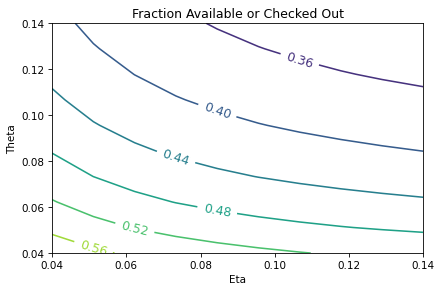

In [462]:
contour(frame)

decorate(xlabel='Eta',
         ylabel='Theta',
         title='Fraction Available or Checked Out')

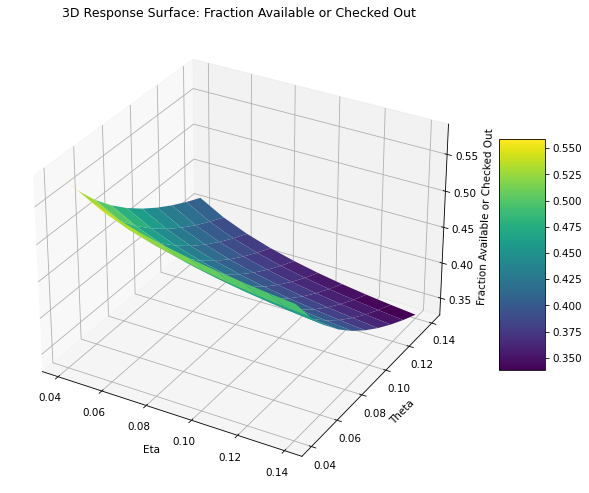

In [463]:
# define x, y, and z
theta_array = frame.index.values
eta_array = frame.columns.values
percent_avail_out = frame.values

# Create a meshgrid for 3D plotting
Eta, Theta = np.meshgrid(eta_array, theta_array)

# Plotting the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Eta, Theta, percent_avail_out, cmap='viridis')

# Adding labels and title
ax.set_xlabel('Eta')
ax.set_ylabel('Theta')
ax.set_zlabel('Fraction Available or Checked Out')
ax.set_title('3D Response Surface: Fraction Available or Checked Out')

# Adding color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()



In [464]:
def plot_sweep_frame(frame):
    for theta in frame.index:
        row = frame.loc[theta]
        for eta in row.index:
            metric = row[eta]
            plt.plot(eta / theta, metric, '.', color='C1')

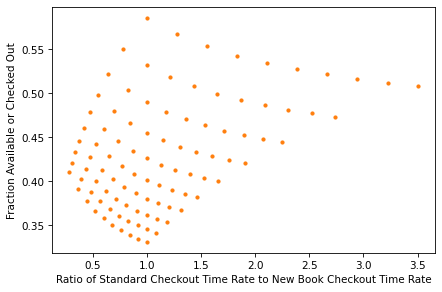

In [465]:
plot_sweep_frame(frame)

decorate(xlabel='Ratio of Standard Checkout Time Rate to New Book Checkout Time Rate',
         ylabel='Fraction Available or Checked Out')

# Validation & Verification

The results are valid because the process and parameters are modeled on the New York Public Library's system of online requests and check outs, including approximations of their rates of transfer from one state to another, including exact values where available. Values like the time in transit (4 days) and the time until a book is re-shelved (1 day) are approximations based on personal observation. The check out times (21 days and 14 days for new books) are exact values from the NYPL.  The quantities of books were scaled down, but their ratios were kept in rough proportion.

The results have been verified because, in sweeping the parameters eta and theta, the simulation was run 100 times. This shows that the results are replicable and therefore verifiable.

# Findings

The contour plot confirms what we know intuitively, that allowing patrons to keep their books checked out longer (lower values of eta and theta) will result in a higher percentage of books that are available or checked out. The response surface curve shows the same results in 3D: the highest point on the graph shows the maximum percentage available/ checked out corresponding to the minimum values of eta and theta, and the lowest point on the graph shows the minimum percentage available/ checked out correponding to the maximum values of eta and theta.

However, if the library uses the maximum simulated check out times (4 weeks) for each type of book, they may find that there is a significant bottleneck of requests waiting in line to be fulfilled. This could cause dissatisfaction and logistical issues, while technically meeting their stated goal of keeping more books in circulation. Looking at the ratio, therefore, of the standard check out time to the new book check out time may provide another useful decision making metric to inform the library's process while balancing competing needs. Interestingly, the plot of this ratio reveals that the maximum percentage available or checked out occurs when the ratio of standard check out time to new book check out time is 1:1. Intuitively, this may threaten patrons' sense of fairness, that the newer, more in-demand books with longer wait times should be returned in a speedier fashion. What this plot also reveals is that when eta > theta, the maximum percentage available or checked out tends to be higher than when eta < theta. We see this on the response surface curve as well, that when eta is very high and theta is very low, the curve is higher than when eta is very low and theta is very high. If eta > theta, then new books are being checked out for longer periods of time than standard books. Essentially, what this tells us is that maximizing the amount of time that the new books are checked out for has more of an impact on the overall proportion of books that are available or in use than maximizing the amount of time that the standard books are checked out for.

One helpful improvement to this model would be to account for renewals. In the system used by the NYPL, new books cannot be renewed, and standard books can be renewed a maximum number of times before being overdue. An additional state, 'renewed,' could be created for standard books which immediately sends the book back into 'checked out' and records the number of times the book has been renewed until the limit has been reached.



